In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
# Parsing file, each line is a Python dictionary
with open("./scrapes/ted_talks.txt", 'r', encoding="utf-8") as infile:
    lines = infile.readlines()
    
talks = [eval(line) for line in lines]

In [3]:
talks[0].keys()

dict_keys(['categories', 'tags', 'language', 'num_views', 'num_comments', 'date', 'speaker_id', 'speaker', 'title', 'tokens', 'duration', 'talk_id', 'event'])

### Duration

In [4]:
durations = [talk["duration"] for talk in talks]

In [5]:
avg_duration_seconds = np.mean(durations)
avg_duration_minutes = avg_duration_seconds / 60
avg_duration_minutes

13.333988049834733

In [6]:
talks[0]["categories"]

[{'count': 20966, 'id': 7, 'name': 'Funny'},
 {'count': 4973, 'id': 1, 'name': 'Beautiful'},
 {'count': 6550, 'id': 9, 'name': 'Ingenious'},
 {'count': 3508, 'id': 3, 'name': 'Courageous'},
 {'count': 419, 'id': 11, 'name': 'Longwinded'},
 {'count': 268, 'id': 2, 'name': 'Confusing'},
 {'count': 8106, 'id': 8, 'name': 'Informative'},
 {'count': 11288, 'id': 22, 'name': 'Fascinating'},
 {'count': 314, 'id': 21, 'name': 'Unconvincing'},
 {'count': 11237, 'id': 24, 'name': 'Persuasive'},
 {'count': 4617, 'id': 23, 'name': 'Jaw-dropping'},
 {'count': 1241, 'id': 25, 'name': 'OK'},
 {'count': 222, 'id': 26, 'name': 'Obnoxious'},
 {'count': 26312, 'id': 10, 'name': 'Inspiring'}]

In [7]:
import matplotlib.pyplot as plt

Text(0.5,1,'Duration vs. Views')

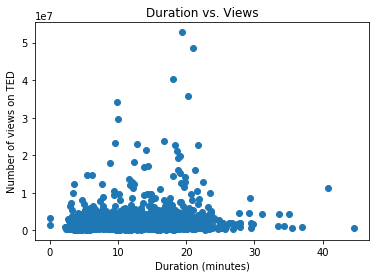

In [9]:
num_views = [talk['num_views'] for talk in talks]
plt.scatter(np.array(durations) / 60, num_views)
plt.xlabel("Duration (minutes)")
plt.ylabel("Number of views on TED")
plt.title("Duration vs. Views")

Text(0.5,1,'Duration vs. Comments')

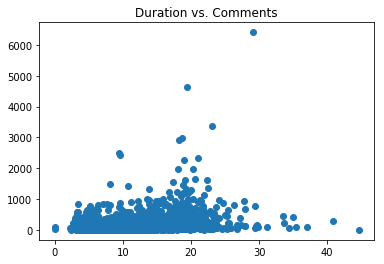

In [19]:
num_comments = [talk['num_comments'] for talk in talks]
plt.scatter(np.array(durations) / 60, num_comments)
plt.title("Duration vs. Comments")

Text(0.5,1,'Views vs. Comments')

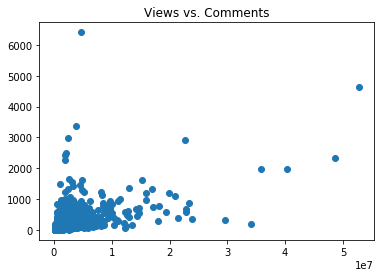

In [11]:
plt.scatter(num_views, num_comments)
plt.title("Views vs. Comments")

In [16]:
np.argmax(num_comments)

150

In [15]:
talks[150]['title'], talks[150]['speaker']

('Militant atheism', 'Richard Dawkins')

In [17]:
np.argmax(num_views)

0

In [18]:
# haha duh, I scraped on views!
talks[0]['title'], talks[0]['speaker']

('Do schools kill creativity?', 'Ken Robinson')

### Get word counts for talks

In [63]:
test_tokens = talks[0]['tokens'][:10]
test_tokens

['Good morning. How are you?',
 '(Laughter)',
 "It's been great, hasn't it?",
 "I've been blown away by the whole thing.",
 "In fact, I'm leaving.",
 '(Laughter)',
 'There have been three themes\nrunning through the conference',
 'which are relevant\nto what I want to talk about.',
 'One is the extraordinary\nevidence of human creativity',
 "in all of the presentations that we've had"]

In [43]:
test_token = test_tokens[7]
test_token

'which are relevant\nto what I want to talk about.'

In [35]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Parker Grey
[nltk_data]     Addison\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [45]:
nltk.word_tokenize(test_token)

['which',
 'are',
 'relevant',
 'to',
 'what',
 'I',
 'want',
 'to',
 'talk',
 'about',
 '.']

That's cool, but it leaves in the punctuation

In [60]:
# Creating a custom tokenizer that only keeps words (groups of chars) or numbers (groups of digits)
from nltk.tokenize import RegexpTokenizer
punct_tokenizer = RegexpTokenizer(r'\w+|\d+')

In [61]:
punct_tokenizer.tokenize(test_token)

['which', 'are', 'relevant', 'to', 'what', 'I', 'want', 'to', 'talk', 'about']

In [62]:
# Unforunately it splits numbers up, but that's not too bad (especially since people actually pronounce numbers) :shrug:
punct_tokenizer.tokenize("1,000,234,543")

['1', '000', '234', '543']

In [64]:
num_words = 0
for token in test_tokens:
    # Ignore audience cues (should start with '(', based on experience at least!)
    if token[0] == '(':
        pass
    else:
        num_words += len(punct_tokenizer.tokenize(token))

In [65]:
num_words

62

In [67]:
punct_tokenizer.tokenize("I'm actually two words: 'I' and 'Am'")

['I', 'm', 'actually', 'two', 'words', 'I', 'and', 'Am']

Alright let's actually get some word counts now

In [68]:
def count_words(tokens):
    
    return sum([len(punct_tokenizer.tokenize(token)) for token in tokens if token[0] != '('])

In [69]:
count_words(test_tokens)

62

In [73]:
# testing first
for talk in talks[:1]:
    talk['num_words'] = count_words(talk['tokens'])

In [74]:
talks[0]['num_words']

3251

In [75]:
# sweet, let's gooooooo
for talk in talks:
    talk['num_words'] = count_words(talk['tokens'])

That was so much quicker than I thought it would be.  Took about 2.5 seconds :')

In [76]:
num_words = [talk['num_words'] for talk in talks]

Text(0.5,1,'Duration vs. Number of Words')

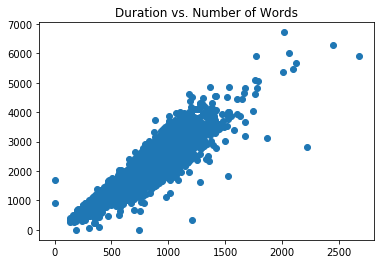

In [78]:
plt.scatter(durations, num_words)
plt.title("Duration vs. Number of Words")

In [79]:
np.corrcoef(durations, num_words)

array([[1.        , 0.91642208],
       [0.91642208, 1.        ]])

### I wonder if presenters who talk fast are considered 'confusing'

In [80]:
words_per_min = np.array(num_words) / (np.array(durations) / 60)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


Yikes, I have some zero durations in there?  I guess I didn't filter out my scrapes enough...

In [81]:
np.argwhere(np.array(durations) == 0)

array([[ 255],
       [1116]], dtype=int64)

In [82]:
talks[255]['title'], talks[255]['speaker']

('How I learned to read -- and trade stocks -- in prison',
 'Curtis "Wall Street" Carroll')

In [83]:
talks[1116]['title'], talks[1116]['speaker']

('How I fail at being disabled', 'Susan Robinson')

Nope! TED messed up on those bad boys, I'll rewrite them manually.

In [86]:
talks[255]['duration'] = 11 * 60 + 4
talks[1116]['duration'] = 7 * 60 + 48

In [88]:
durations = np.array([talk['duration'] for talk in talks])
words_per_min = np.array(num_words) / (durations / 60)

In [89]:
rankings = np.array([talk['categories'] for talk in talks])

In [110]:
# For each set of rankings I'll need to go through the list until I find 'name':'Confusing' or 'id' == 2
confusing_rankings = []
for talk_rankings in rankings:
    for rank in talk_rankings:
        if rank['name'] == 'Confusing':
            confusing_rankings.append(rank['count'])
            # I just hope that all the talks have a 'confusing' ranking... otherwise I'll need to default the value to zero

In [111]:
len(confusing_rankings)

2622

Nice!

Text(0.5,1,"Words per Min vs. Number of 'Confusing' Rankings (not normalized)")

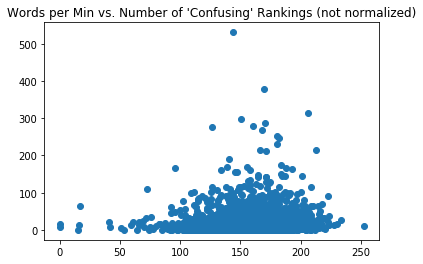

In [96]:
plt.scatter(words_per_min, confusing_rankings)
plt.title("Words per Min vs. Number of 'Confusing' Rankings (not normalized)")

Let me normalize the number of confusing rankings to the number of total rankings

In [112]:
total_rankings = []
for talk_rankings in rankings:
    total_rankings.append(sum([rank['count'] for rank in talk_rankings]))
        

In [113]:
total_rankings = np.array(total_rankings)
confusing_rankings = np.array(confusing_rankings)

In [114]:
# This should now be the percent of rankings that were 'confusing'
confusing_rankings_percent = confusing_rankings / total_rankings * 100

Text(0.5,1,"Words per Min vs. Percent 'Confusing' Rankings")

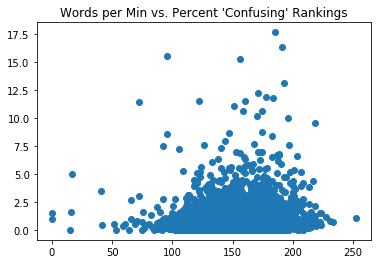

In [119]:
plt.scatter(words_per_min, confusing_rankings_percent)
plt.title("Words per Min vs. Percent 'Confusing' Rankings")

Not too convincing... but there **is** a positive trend if you don't focus on the giant heap of blue

In [126]:
np.corrcoef(words_per_min, confusing_rankings_percent, 1)

array([[1.        , 0.05818168],
       [0.05818168, 1.        ]])

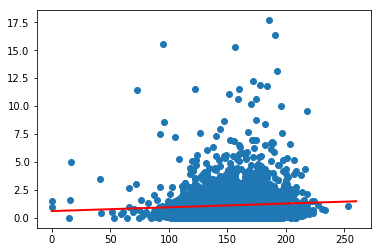

In [132]:
plt.scatter(words_per_min, confusing_rankings_percent)
plt.plot([0, 260], np.poly1d(np.polyfit(words_per_min, confusing_rankings_percent, 1))([0, 260]), c='r', lw=2)

Heh... at least it seems like there is a significant correlation.

In [133]:
from scipy.stats import pearsonr

In [134]:
pearsonr(words_per_min, confusing_rankings_percent)

(0.05818167771603329, 0.0028794345505513044)